In [163]:
import pandas as pd
import matplotlib.pyplot as plt

In [164]:
# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3  # Maximum depth for the decision tree

In [165]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    #maintaining a dictionary storing the number of occurance of each label
    labels_freq={}

    for row in data:
        if row[-1] not in labels_freq:
            labels_freq[row[-1]]=0
        labels_freq[row[-1]]+=1
    
    n=len(data)  #total rows

    gini=1
    for p in labels_freq.values():
        prob=p/n
        gini-=prob**2
    return gini

In [166]:

def split_data(data, attribute_index, value):
    
    list= [row for row in data if row[attribute_index]==value]
    return list


In [167]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
  
    gini_parent=calculate_gini(data) 
    values = set(row[attribute_index] for row in data)
    gini_child=0

    for value in values:
        child_data=split_data(data,attribute_index,value)
        gini_child+=((len(child_data))/len(data))*calculate_gini(child_data)
    gain=gini_parent-gini_child
    return gain

In [168]:
def build_tree(data, attributes, depth=0):

    if calculate_gini(data) == 0:
        return data[0][-1]  

    if not attributes or depth >= MAX_DEPTH or len(data) <= COUNT_THRESHOLD:
        labels = [row[-1] for row in data]
        return max(set(labels), key=labels.count) 

    best_attribute = max(attributes, key=lambda attr: gini_gain(data, attr))
    best_gain = gini_gain(data, best_attribute)

    if best_gain == 0:
        labels = [row[-1] for row in data]
        return max(set(labels), key=labels.count)

    tree = {best_attribute: {}}
    values = {row[best_attribute] for row in data}

    for value in values:
        subset = split_data(data, best_attribute, value)
        if not subset: 
            labels = [row[-1] for row in data]
            tree[best_attribute][value] = max(set(labels), key=labels.count)
        else:
            att = [attr for attr in attributes if attr != best_attribute]
            tree[best_attribute][value] = build_tree(subset, att, depth + 1)

    return tree



In [169]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    """
    Predicts the label for a single instance using the decision tree.

    Args:
        tree: The decision tree (dictionary).
        instance: A dictionary where keys are attribute indices and values are the instance's attribute values.

    Returns:
        The predicted label for the instance.
    """
    # Hint: Traverse the tree based on the instance's attribute values.
    # Hint: If the current node is a dictionary, look up the next branch using the instance value.
    # Hint: If the current node is not a dictionary, return it as the predicted label.
    
    if type(tree)!=dict:
        return tree
    
    attribute_index=next(iter(tree))

    attribute_value=instance.get(attribute_index)

    subtree=tree[attribute_index].get(attribute_value)

    return predict(subtree,instance)

In [170]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])  # Drop the target column
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # Map target to numerical values

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes (buying, maint, etc.)
attribute_names = list(X.columns)  # Get the actual attribute names


In [171]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)

Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


<Figure size 1400x800 with 0 Axes>

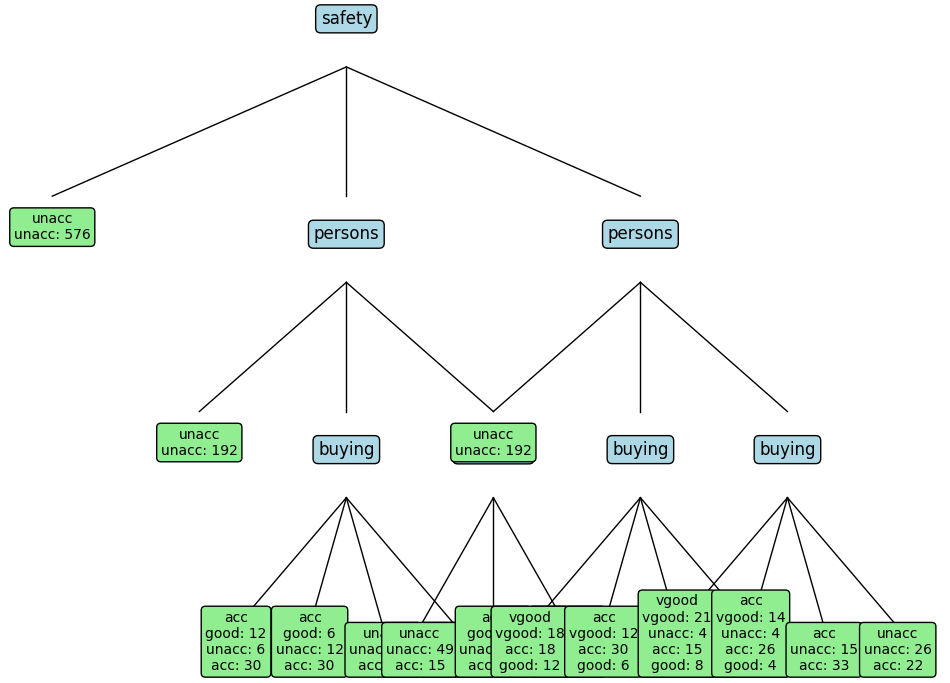

In [172]:

# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        # Count the occurrences of each label in the current leaf data subset
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        # Format the label text to include counts of each class
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap  # Calculate child x position
        child_y = y_offset - 0.1  # Shift vertically for the child nodes

        # Draw a line to the child node
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)

        # Recursively call plot_tree for the child node, passing the subset of data that corresponds to the child
        subset = split_data(data, root, value)  # Get the subset of data for this child
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:  # Show the plot only at the top level
        plt.show()



# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)

In [173]:
# Test prediction
test_instance = {0: 1, 1: 2}  # Middle-aged with High income
prediction = predict(tree, test_instance)
print("\nPrediction for test instance:", "Yes" if prediction == 1 else "No")


Prediction for test instance: No
